# Метрические методы классификации 1NN и kNN

**Задание**

* Найдите лучшую комбинацию функции расстояния, окна и ядра для метода ближайших соседей. 
* Для лучшей найденной комбинации постройте графики зависимости F-меры от числа ближайших соседей и ширины окна. 
* Используйте Leave-One-Out перекрёстную проверку для подсчёта F-меры.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Краткий обзор данных

In [2]:
data = pd.read_csv("data/iris.csv")
data.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
data.info()
data["class"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepallength    150 non-null float64
sepalwidth     150 non-null float64
petallength    150 non-null float64
petalwidth     150 non-null float64
class          150 non-null object
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Всего имеется три класса и четыре количественных признака. Пропусков нет.

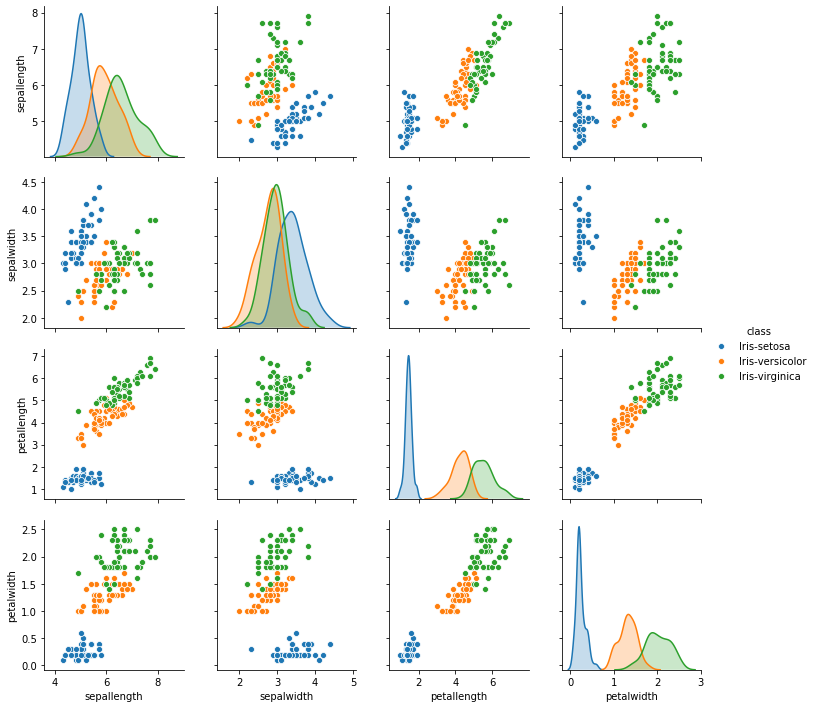

In [4]:
sns.pairplot(data, hue="class")

Визуально аутлаеров нет. Дополнительная предобработка данных не требуется.

Данные хорошо кластеризуются, поэтому классификация должна дать хороший результат.

### Подготовка данных

In [5]:
X = data.drop(columns=["class"])

Закодируем классы в числа

In [6]:
lb_maker = LabelEncoder()
y = lb_maker.fit_transform(data["class"])

Нормализация данных

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Итоговый датасет

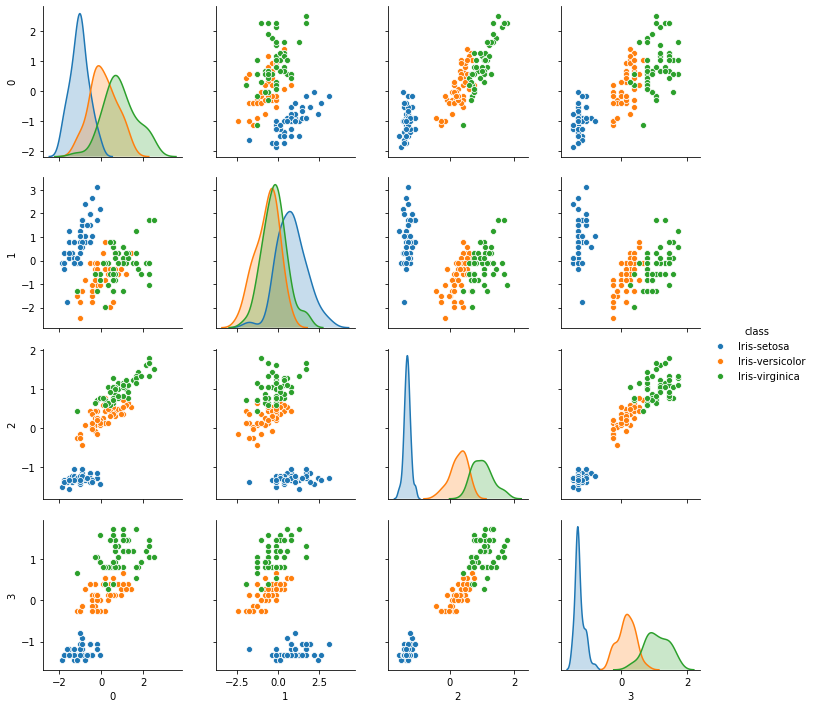

In [8]:
sns.pairplot(pd.concat([pd.DataFrame(X_scaled),data["class"]],axis=1),hue="class")

## Формализация понятия "близости"

Функция метрики на множестве $X$: $$\rho: X \times X \rightarrow [0;+\infty).$$

Для определения близости объектов чаще всего используют следующие метрики:

1. Минковского $$ \rho (x,y)=\left(\sum_i |x_i-y_i|^p\right)^{\frac{1}{p}},$$ 
в частных случаях берут $p=1$ (Manhattan), $p=2$ (Euclidian), $p=\infty$ (Chebyshev).


2. Расстояние Махаланобиса $$\rho(x,y) = \sqrt{(x-y)^{\mathrm T}\mathbf{S}^{-1}(x-y)}, $$
для векторов из одного распределения с ковариационной матрицей $\mathbf S$.


In [9]:
def euclidian(x, y):
    return np.sqrt((x-y)*np.matrix(x-y).T)[0, 0]
    
def manhattan(x, y):
    return np.sum(np.abs(x-y))
    
def chebyshev(x,y):
    return np.max(np.abs(x-y))
    
def mahalanobis(x,y,ss):
    return np.sqrt(np.matrix(x-y).T*np.linalg.pinv(ss)*(x-y))

## Метрический классификатор

Для произвольного $x \in X$ отранжируем объекты $x_1,\ldots,x_l$:

$$\rho (x,x^{(1)}) \leq \rho(x,x^{(2)}) \leq \ldots \leq \rho (x, x^{(l)}), $$

$x^{(i)} - $ $i$-й сосед обекта $x$ среди $x_1,\ldots,x_l$;\
$y^{(i)} - $ ответ на $i$-м соседе объекта $x$.

**Метрический алгоритм классификации:**
$$ a(x; X^l) = \arg \max_{y\in Y} \sum_{i=1}^l [y^{(i)}=y]\, w(i,x),$$
$w(i,x) - $ вес (степень важности) $i$-го соседа объекта x.

### Метод $k$ ближайших соседей ($k$ nearest neighbors, kNN)

$w(i,x)=[i\leq 1]\,- $ метод ближайшего соседа\
$w(i,x)=[i\leq k]\,-$ метод $k$ ближайших соседей

![alt text](data/diagramintro.jpg)

*Преимущества:*
* простота реализации;
* интерпретируемость;
* параметр k можно оптимизировать по критерию скользящего контроля (leave-one-out): 

$$\mathrm{LOO}(k,X^l) = \sum_{i=1}^l \left [a(x_i;X^l\setminus \{x_i \}, k) \neq y_i \right ] \rightarrow \min_k .$$

*Недостатки:*
* чувствительность к шуму;
* низкая эффективность;
* не учитываются расстояния между объектами.

### Метод $k$ взвешенных ближайших соседей

Рассмотим $w(i,x)=[i\leq k]w_{(i,x)}$. В качестве $w_{(i,x)}$ можно брать:
* линейно убывающую функцию $w_i = \frac{k+1-i}{k}$;
* экспоненциально убывающие веса $w_i = q^i, 0<q<1$;
* ядерные функции.

**Kernel functions**

Функции ядра удовлетворяют следующим соотношениям: 
1. $\displaystyle \int _{-\infty }^{+\infty }K(u)\,du=1 ; $

2. $K(-u)=K(u){\mbox{ for all values of }}u\,.$

Часто используемые ядерные функции
![alt text](data/Kernels.svg.png)

In [10]:
def uniform(r):
    return 1 / 2 if abs(r)<=1 else 0

def triangle(r):
    return (1 - abs(r)) if abs(r)<=1 else 0

def epanechnikov(r):
    return (1 - r ** 2) * 3 / 4 if abs(r)<=1 else 0

def quartic(r):
    return (1 - r ** 2) ** 2 * 15 / 16 if abs(r)<=1 else 0

def triweight(r):
    return 35 / 32 * (1 - r ** 2) ** 3 if abs(r)<=1 else 0

def gaussian(r):
    return 1 / np.sqrt(2 * np.pi) * np.exp((-0.5) * r ** 2)

def cosine(r):
    return np.pi / 4 * np.cos(np.pi / 2 * r) if abs(r)<=1 else 0

**Метод окна Парзена**

$\displaystyle w(i,x)=K\left(\frac{\rho(x,x^{(i)})}{h}\right),$ где $h - $ ширина окна.

Метод парзеновского окна фиксированной ширины:
$$ \displaystyle a(x;X^l,h,K) =\arg\max_{y\in Y} \sum_{i=1}^l [y_i = y]\,K\left( \frac{\rho(x,x_i)}{h} \right).$$

Метод парзеновского окна переменной ширины:
$$ \displaystyle a(x;X^l,k,K) =\arg\max_{y\in Y} \sum_{i=1}^l [y_i = y]\,K\left( \frac{\rho(x,x_i)}{\rho(x,x^{(k+1)})} \right).$$

Оптимизация параметров $-$ по критерию LOO:
* выбор метрики $\rho$
* выбор ширины окна $h$ или числа соседей $k$
* выбор ядра $K$

**Выбор параметров**

Ядерные функции влияют на гладкость границы, ширина окна существенно влияет на точность классификации. При маленьком $h$ есть риск переобучения, при большом рискуем получить слишком грубый классификатор.

### Оценка качества классификатора (f1 score)

Для начала рассмотрим случай бинарной классификации

![alt text](data/table_diagnostic.png)

𝐅𝐍 называется ошибкой первого рода\
𝐅𝐏 называется ошибкой второго рода

**Accuracy**

Accuracy — самая простая оценка классификации:
$$ Accuracy=\frac{TP+TN}{TP+TN+FP+FN}.$$

По сути это вероятность того, что класс будет предсказан правильно.

* Работает для многоклассовой классификации.
* Плохо работает в случае, когда элементов одного из классов сильно больше, чем других. В таком случае константное предсказание может давать высокое значение accuracy.

**Precision**

$$Precision = \frac{TP}{TP+FP}. $$

Полнота показывает, какую долю объектов, реально относящихся к положительному классу, мы предсказали верно.

* Только бинарная классификация.
* Не зависит от сбалансированности выборки.

**Recall**

$$Recall = \frac{TP}{TP+FN}.$$

Полнота показывает, какую долю объектов, реально относящихся к положительному классу, мы предсказали верно.

* Только бинарная классификация.
* Не зависит от сбалансированности выборки.

**F-measure**

Точность и полнота хорошо оценивают качество классификатора для задач с смещенной априорной вероятностью, но если мы обучили модель с высокой точностью, то может случиться так, что полнота у такого классификатора низкая и наоборот. Чтобы связать точность с полнотой вводят F-меру как среднее гармоническое точности и полноты:

$$F_{measure}=2\frac{Precision \cdot Recall}{Precision + Recall} $$

**Многоклассовая классификация**

Изначально F-мера определена только для бинарной классификации. В данном случае можно использовать несколько подходов:
* One vs one classification
* One vs all (one vs rest
* Hierarchical classification
* Confusion matrix

https://simonhessner.de/why-are-precision-recall-and-f1-score-equal-when-using-micro-averaging-in-a-multi-class-problem/

In [11]:
def f1_score(y_pr, y_tr, average="micro"):
    cm = confusion_matrix(y_pr,y_tr)
    result_score = 0
    if average == 'macro':
        f_scores = np.zeros(cm.shape[0])
        for idx in range(len(f_scores)):
            tp = cm[idx, idx]
            fp = np.sum(cm[idx, :]) - tp
            fn = np.sum(cm[:, idx]) - tp
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f_scores[idx] = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        result_score = np.mean(f_scores)
    elif average == 'micro':
        tp = np.trace(cm)
        fp = fn = np.sum(cm) - tp
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        result_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return result_score

### Реализация классификатора

In [1]:
globals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['', 'globals()'],
 '_oh': {},
 '_dh': ['C:\\Users\\z003zywu\\subprojects\\labs\\1. kNN'],
 'In': ['', 'globals()'],
 'Out': {},
 'get_ipython': <bound method InteractiveShell.get_ipython of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x000001FCD980E898>>,
 'exit': <IPython.core.autocall.ZMQExitAutocall at 0x1fcda4779b0>,
 'quit': <IPython.core.autocall.ZMQExitAutocall at 0x1fcda4779b0>,
 '_': '',
 '__': '',
 '___': '',
 '_i': '',
 '_ii': '',
 '_iii': '',
 '_i1': 'globals()'}

In [12]:
class KNNClassifier:
    
    def __init__(self, window, metric, kernel_name):
        self.window = window # fixed or variable
        self.metric = metric
        self.kernel_name = kernel_name
        self.neighbor_param = None
        self.f_scores = None
        self.best_score = None
        self.distances = None
        
    def rho(self, x, y):
        return globals()[self.metric](np.array(x), np.array(y))
        
    def kernel(self, r):
        return globals()[self.kernel_name](r)
    
    def classify(self, y_train, neighbor_param, idx_row):
        dists = self.distances[idx_row,:]
        dists_argsort = self.distances_argsort[idx_row,:]
        classes = list(set(y_train)) 
        closeness = np.zeros_like(classes,dtype=np.float32) 
        
        if self.window == 'fixed':
            h = neighbor_param
            n_neighbors = np.argmax(dists[dist_argsort] > h) if any(dists[dist_argsort] > h) else len(dists) + 1
        elif self.window == 'variable':
            n_neighbors = neighbor_param
            h = dists[dists_argsort[n_neighbors]]
        for idx in range(n_neighbors):
            neighbor_class = y_train[dists_argsort[idx]]
            closeness[neighbor_class] += self.kernel(dists[dists_argsort[idx]]/h)
        y_predict = classes[np.argmax(closeness)]
        return y_predict
    
    def fit(self, X, y):
        # distance precalculation
        self.distances = np.empty((len(y), len(y)-1))
        self.distances_argsort = np.empty((len(y), len(y)-1),dtype=np.int)
        for idx_i in range(len(y)-1):
            for idx_j in range(idx_i+1, len(y)):
                self.distances[idx_j, idx_i] = self.distances[idx_i, idx_j-1] = self.rho(X[idx_i,:], X[idx_j,:])
        for idx_i in range(len(y)):
            self.distances_argsort[idx_i,:] = np.argsort(self.distances[idx_i,:])
        # LOO optimization    
        self.f_scores = np.zeros(2*len(y)//3)
        for nn in range(1, len(self.f_scores)):         
            y_pred = np.zeros(X.shape[0])
            for idx_row in range(X.shape[0]):
                y_train = np.delete(y, idx_row)
                y_pred[idx_row] = self.classify(y_train,nn,idx_row)
            f_score = f1_score(y_pred, y)
            self.f_scores[nn] = f_score
        self.n_neighbors = np.argmax(self.f_scores)
        self.best_score = self.f_scores[self.n_neighbors]
        print(f"Metric: {self.metric}, kernel: {self.kernel_name}, n_neighbors: {self.n_neighbors}, f_score: {self.best_score}")
        return self.n_neighbors, self.best_score

In [13]:
metrics = ['manhattan', 'chebyshev', 'euclidian']
kernels = ['uniform', 'triangle', 'epanechnikov', 'quartic', 'triweight', 'gaussian', 'cosine']
f_scores = np.zeros((len(metrics),len(kernels)))
n_neighbors = np.zeros((len(metrics),len(kernels)))
for idx_m in range(len(metrics)):
    for idx_k in range(len(kernels)):
        knn = KNNClassifier('variable', metrics[idx_m], kernels[idx_k])
        knn.fit(X_scaled,y)
        f_scores[idx_m, idx_k] = round(knn.best_score,4)
        n_neighbors[idx_m, idx_k] = knn.n_neighbors

C:\Users\z003zywu\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


Metric: manhattan, kernel: uniform, n_neighbors: 15, f_score: 0.96
Metric: manhattan, kernel: triangle, n_neighbors: 63, f_score: 0.9533333333333334
Metric: manhattan, kernel: epanechnikov, n_neighbors: 5, f_score: 0.9533333333333334
Metric: manhattan, kernel: quartic, n_neighbors: 70, f_score: 0.9533333333333334
Metric: manhattan, kernel: triweight, n_neighbors: 78, f_score: 0.9533333333333334
Metric: manhattan, kernel: gaussian, n_neighbors: 15, f_score: 0.96
Metric: manhattan, kernel: cosine, n_neighbors: 58, f_score: 0.9533333333333334
Metric: chebyshev, kernel: uniform, n_neighbors: 18, f_score: 0.96
Metric: chebyshev, kernel: triangle, n_neighbors: 3, f_score: 0.9533333333333334
Metric: chebyshev, kernel: epanechnikov, n_neighbors: 3, f_score: 0.9533333333333334
Metric: chebyshev, kernel: quartic, n_neighbors: 3, f_score: 0.9533333333333334
Metric: chebyshev, kernel: triweight, n_neighbors: 43, f_score: 0.96
Metric: chebyshev, kernel: gaussian, n_neighbors: 11, f_score: 0.96
Metr

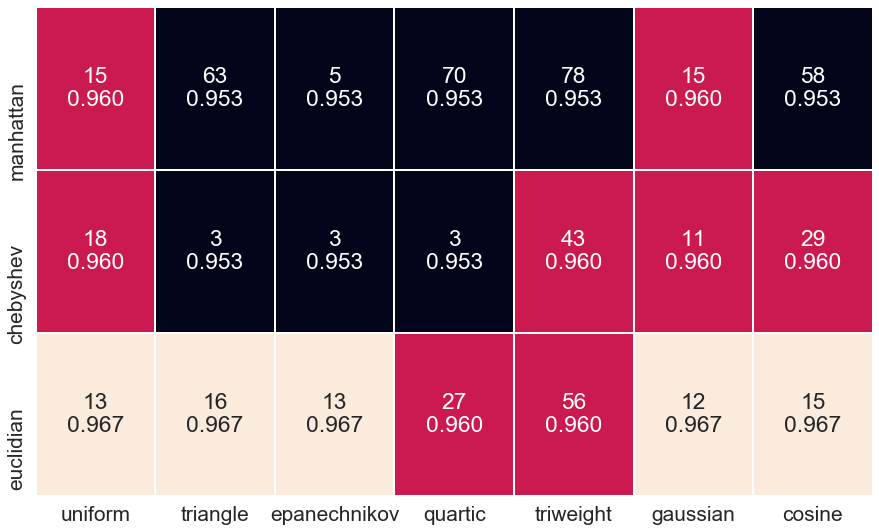

In [14]:
labels = (np.asarray([f"{nn:.0f}\n{f_score:.3f}" for nn, f_score in zip(n_neighbors.flatten(), f_scores.flatten())],dtype=str)).reshape(len(metrics),len(kernels))
sns.set(font_scale=1.9)
f, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(f_scores,linewidths=1,annot=labels,fmt='',ax=ax,cbar=False,xticklabels=kernels,yticklabels=metrics)

Как видно, лучше всего в данном случае классификатор работает с евклидовым расстоянием.\
Построим графики зависимости F-меры от числа ближайших соседей для лучших ядер.

In [16]:
scores = {}
for kernel in ['uniform', 'triangle', 'epanechnikov', 'gaussian', 'cosine']:
    knn = KNNClassifier("variable", "euclidian", kernel)
    knn.fit(X_scaled, y)
    scores[kernel] = knn.f_scores
df_scores = pd.DataFrame(data=scores)


C:\Users\z003zywu\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


Metric: euclidian, kernel: uniform, n_neighbors: 13, f_score: 0.9666666666666667
Metric: euclidian, kernel: triangle, n_neighbors: 16, f_score: 0.9666666666666667
Metric: euclidian, kernel: epanechnikov, n_neighbors: 13, f_score: 0.9666666666666667
Metric: euclidian, kernel: gaussian, n_neighbors: 12, f_score: 0.9666666666666667
Metric: euclidian, kernel: cosine, n_neighbors: 15, f_score: 0.9666666666666667


Text(0, 0.5, 'F-score')

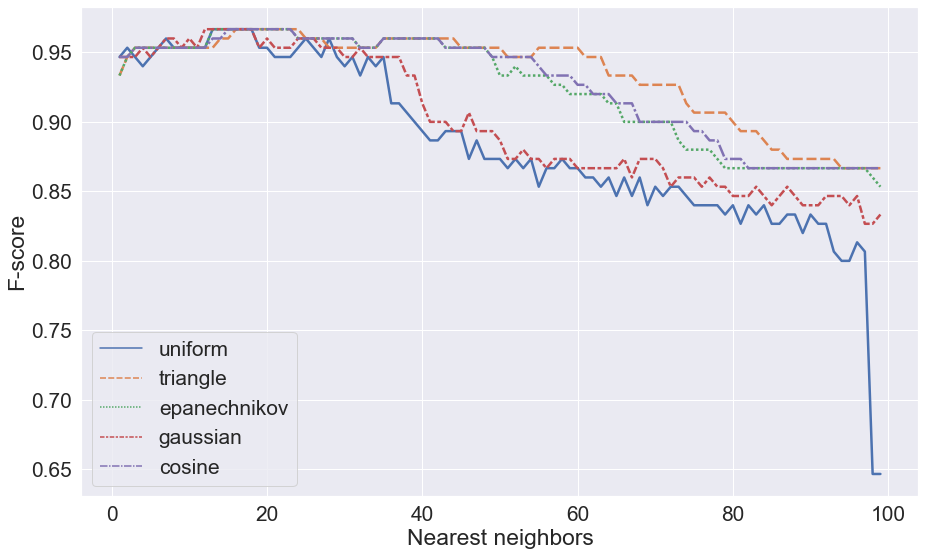

In [21]:
f, ax = plt.subplots(figsize=(15, 9))
sns.lineplot(data=df_scores.drop(index=0), ax=ax, linewidth=2.5)
plt.xlabel("Nearest neighbors")
plt.ylabel("F-score")

Text(0, 0.5, 'F-score')

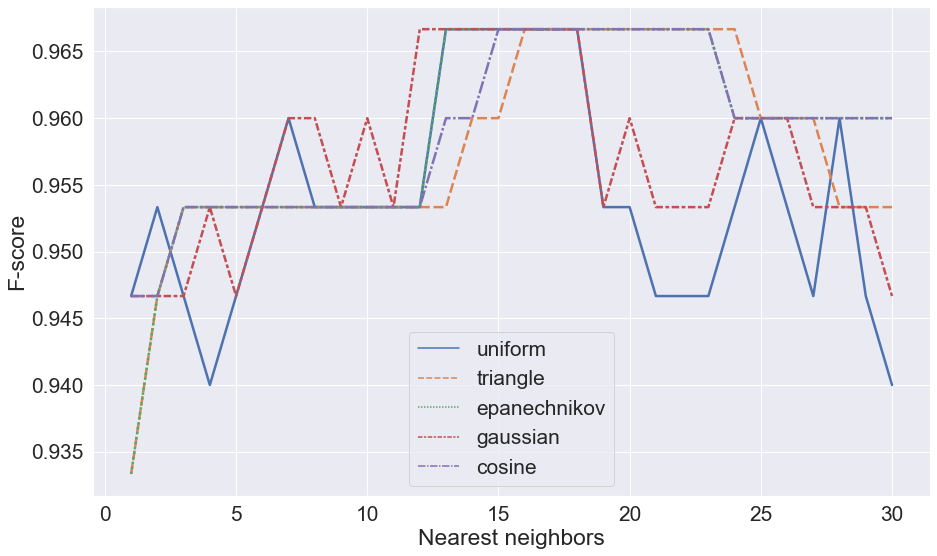

In [22]:
f, ax = plt.subplots(figsize=(15, 9))
sns.lineplot(data=df_scores.drop(index=0).iloc[:30,:], ax=ax, linewidth=2.5)
plt.xlabel("Nearest neighbors")
plt.ylabel("F-score")